**Conda environment: conda_scRNA-seq**

**Import libraries and dependencies**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.font_manager as fm
import scanpy as sc
import torch
import scvi
import scvelo as scv
import anndata
import re
import seaborn as sns
import sctour as sct
from tqdm import tqdm



os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [29]:
# Matrix multiplication balancing precision and computational efficiency (options: medium-high-highest)
torch.set_float32_matmul_precision("high")

# Highest level of verbosity
sc.settings.verbosity = 3  
scv.settings.verbosity = 3

# Reproducibility
scvi.settings.seed = 1

# Figures
scv.set_figure_params(style="scvelo")

# Use Times New Roman as font
font_path = '/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/supp_data/misc/Times_New_Roman.ttf'
fm.fontManager.addfont(font_path)
prop = fm.FontProperties(fname=font_path)
pl.rcParams['font.family'] = 'sans-serif'
pl.rcParams['font.sans-serif'] = prop.get_name()

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Seed set to 1


In [30]:
# Select samples
os.chdir('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/1-2_scKB_mapping')
samples = ['0h_1_scKB','0h_2_scKB','2h_1_scKB','2h_2_scKB','4h_1_scKB','4h_2_scKB','10h_1_scKB','10h_2_scKB']

# Directory with multiple files required below
analysis_dir = '/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/supp_data/misc/'

In [31]:
# Read anndata objects and concatenate them
adatas = {}
for sample in samples:
    adata_path = f'/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/2-COPILOT/h5ad_files_spliced/{sample}_COPILOT.h5ad'
    adatas[sample] = anndata.read_h5ad(adata_path)

    print(adatas[sample])

adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],batch_key='sample',batch_categories=adatas.keys(),index_unique=None, join="outer")
adata.obs_names_make_unique()
del(adatas)

AnnData object with n_obs × n_vars = 8349 × 27643
    layers: 'spliced', 'unspliced'
AnnData object with n_obs × n_vars = 6993 × 27795
    layers: 'spliced', 'unspliced'
AnnData object with n_obs × n_vars = 10371 × 26845
    layers: 'spliced', 'unspliced'
AnnData object with n_obs × n_vars = 11971 × 27086
    layers: 'spliced', 'unspliced'
AnnData object with n_obs × n_vars = 9269 × 26937
    layers: 'spliced', 'unspliced'
AnnData object with n_obs × n_vars = 8419 × 26885
    layers: 'spliced', 'unspliced'
AnnData object with n_obs × n_vars = 5899 × 26313
    layers: 'spliced', 'unspliced'
AnnData object with n_obs × n_vars = 7830 × 26393
    layers: 'spliced', 'unspliced'


In [32]:
# Rename samples
adata.obs['batch'] = adata.obs['sample']
adata.obs['experiment'] = adata.obs['sample']
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('0h_'), '0h', adata.obs['experiment'])
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('2h_'), '2h', adata.obs['experiment'])
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('4h_'), '4h', adata.obs['experiment'])
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('10h_'), '10h', adata.obs['experiment'])
adata.obs['experiment'] = adata.obs['experiment'].astype('category')

In [33]:
# Read output of scVI_scANVI file to annotate cell types and developmental stages
adata_annotation = sc.read_h5ad('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/3-2_anndata_obj/MINI-EX_adata_all.h5ad')
print(adata_annotation)

AnnData object with n_obs × n_vars = 65218 × 30721
    obs: 'sample', 'batch', 'experiment', 'shahan_celltype', 'shahan_developmental', '_scvi_batch', '_scvi_labels', 'final_annotation_celltype_0.7', 'final_annotation_celltype_0.8', 'final_annotation_celltype_0.9', 'unannotated_2_likely', 'unannotated_2_likely_merged', 'lineage_low_confidence', 'final_lineages', '_prediction', 'final_annotation_developmental_0.7', 'final_annotation_developmental_0.8', 'final_annotation_developmental_0.9', 'final_clustering', 'final_celltype', 'final_annotation_MINI-EX', 'number_final_annotation_MINI-EX'
    var: 'gene_symbol'


In [34]:
# Retrieve annotations
adata.obs["final_celltype"]=adata_annotation.obs["final_celltype"]
adata.obs["final_annotation_developmental_0.7"]=adata_annotation.obs["final_annotation_developmental_0.7"]
adata.obs["final_lineages"]=adata_annotation.obs["final_lineages"]
adata.obs["final_annotation_MINI-EX"]=adata_annotation.obs["final_annotation_MINI-EX"]

In [35]:
print(adata.obs['final_annotation_developmental_0.7'].value_counts())
print(adata.obs['final_celltype'].value_counts())
print(adata.obs['final_celltype'])
print(adata)

Meristem                     23045
Elongation                   17806
Maturation                    9371
Proximal Lateral Root Cap     8424
                              3147
Proximal Columella            1347
Distal Lateral Root Cap       1100
Distal Columella               978
Name: final_annotation_developmental_0.7, dtype: int64
Atrichoblast                   10455
Lateral Root Cap                9524
Xylem Pole Pericycle            8419
Trichoblast                     8339
Endodermis                      5952
Procambium                      5330
Cortex                          4225
Phloem Pole Pericycle           2922
Columella                       2325
Metaxylem                       1499
Metaphloem & Companion Cell     1433
Protoxylem                      1092
Protophloem                      488
Unknown0                         484
Unknown1                         439
Unknown2                         365
Unknown6                         357
Unknown4                         345

In [36]:
# Total number of cells
print(len(adata.obs["final_celltype"]))

# Create a mask to find rows where either of the specified columns has NA values (removed cells)
mask = adata.obs["final_celltype"].isna() | adata.obs["final_annotation_developmental_0.7"].isna()
adata = adata[~mask]

# Verify the number of remaining cells
print(len(adata.obs["final_celltype"]))

69101
65218


In [37]:
# Define the GTF file path
gtf_file = f'{analysis_dir}/genes.gtf'

# Dictionary to store gene_id -> gene_name mapping
gene_dict = {}

# Open and process the GTF file
with open(gtf_file, "r") as f:
    for line in f:
        if line.startswith("#"):  # Skip header lines
            continue

        fields = line.strip().split("\t")
        if fields[2] != "gene":  # Filter only "gene" entries
            continue

        # Extract attributes (last column)
        attributes = fields[8]

        # Use regex to extract gene_id and gene_name
        gene_id_match = re.search(r'gene_id "([^"]+)"', attributes)
        gene_name_match = re.search(r'gene_name "([^"]+)"', attributes)

        if gene_id_match and gene_name_match:
            gene_id = gene_id_match.group(1)  # Extract ATG ID (e.g., AT5G57620)
            gene_name = gene_name_match.group(1)  # Extract gene name (e.g., MYB36)
            gene_dict[gene_id] = gene_name  # Store in dictionary

# Print a preview
print({k: gene_dict[k] for k in list(gene_dict)[:100]})

# Assuming `adata` is your AnnData object
adata.var["gene_symbol"] = adata.var_names.map(gene_dict)

{'AT1G30814': 'AT1G30814', 'AT1G78930': 'AT1G78930', 'AT1G71695': 'AT1G71695', 'AT1G58983': 'AT1G58983', 'AT1G12980': 'ESR1', 'AT1G45223': 'AT1G45223', 'AT1G56250': 'PP2-B14', 'AT1G66852': 'AT1G66852', 'AT1G69810': 'WRKY36', 'AT1G72450': 'JAZ6', 'AT1G76280': 'AT1G76280', 'AT1G65630': 'DEG3', 'AT1G71390': 'RLP11', 'AT1G56233': 'AT1G56233', 'AT1G15210': 'ABCG35', 'AT1G15250': 'AT1G15250', 'AT1G79700': 'WRI4', 'AT1G62895': 'AT1G62895', 'AT1G73360': 'HDG11', 'AT1G16360': 'AT1G16360', 'AT1G10225': 'AT1G10225', 'AT1G26670': 'VTI1B', 'AT1G34855': 'AT1G34855', 'AT1G52200': 'AT1G52200', 'AT1G57800': 'VIM5', 'AT1G69460': 'AT1G69460', 'AT1G04310': 'ERS2', 'AT1G08080': 'ACA7', 'AT1G75550': 'AT1G75550', 'AT1G71890': 'SUC5', 'AT1G05430': 'AT1G05430', 'AT1G80870': 'AT1G80870', 'AT1G75310': 'AUL1', 'AT1G02010': 'SEC1A', 'AT1G47900': 'AT1G47900', 'AT1G14315': 'AT1G14315', 'AT1G26760': 'SDG35', 'AT1G05250': 'AT1G05250', 'AT1G67260': 'TCP1', 'AT1G24575': 'AT1G24575', 'AT1G12790': 'AT1G12790', 'AT1G04850'

In [38]:
adata.raw = adata.copy()

In [39]:
# Remove mitochondrial, chloroplast and protoplasting-associated genes
mito_genes = adata.var_names.str.startswith("ATMG")  # Mitochondrial genes
chloro_genes = adata.var_names.str.startswith("ATCG")  # Chloroplast genes

# Define protoplasting-induced genes
pp_genes = pd.read_csv(f'{analysis_dir}/Protoplasting_DEgene_FC2_list.txt', header=None)[0].tolist()
pp_genes_mask = adata.var_names.isin(pp_genes)  # Find matching genes

# Combine all masks
genes_to_remove = mito_genes | chloro_genes | pp_genes_mask

# Filter out these genes
adata = adata[:, ~genes_to_remove].copy()

# Check the remaining number of genes
print(f"Remaining genes: {adata.n_vars}")

Remaining genes: 27097


In [40]:
adata.write_h5ad('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/3-2_anndata_obj/sctour_preprocessing.h5ad')

... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


In [41]:
adata = anndata.read_h5ad('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/3-2_anndata_obj/sctour_preprocessing.h5ad')

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Running using GPU.
Epoch 400: 100%|██████████| 400/400 [00:32<00:00, 12.33epoch/s, train_loss=947, val_loss=1.02e+3]    


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


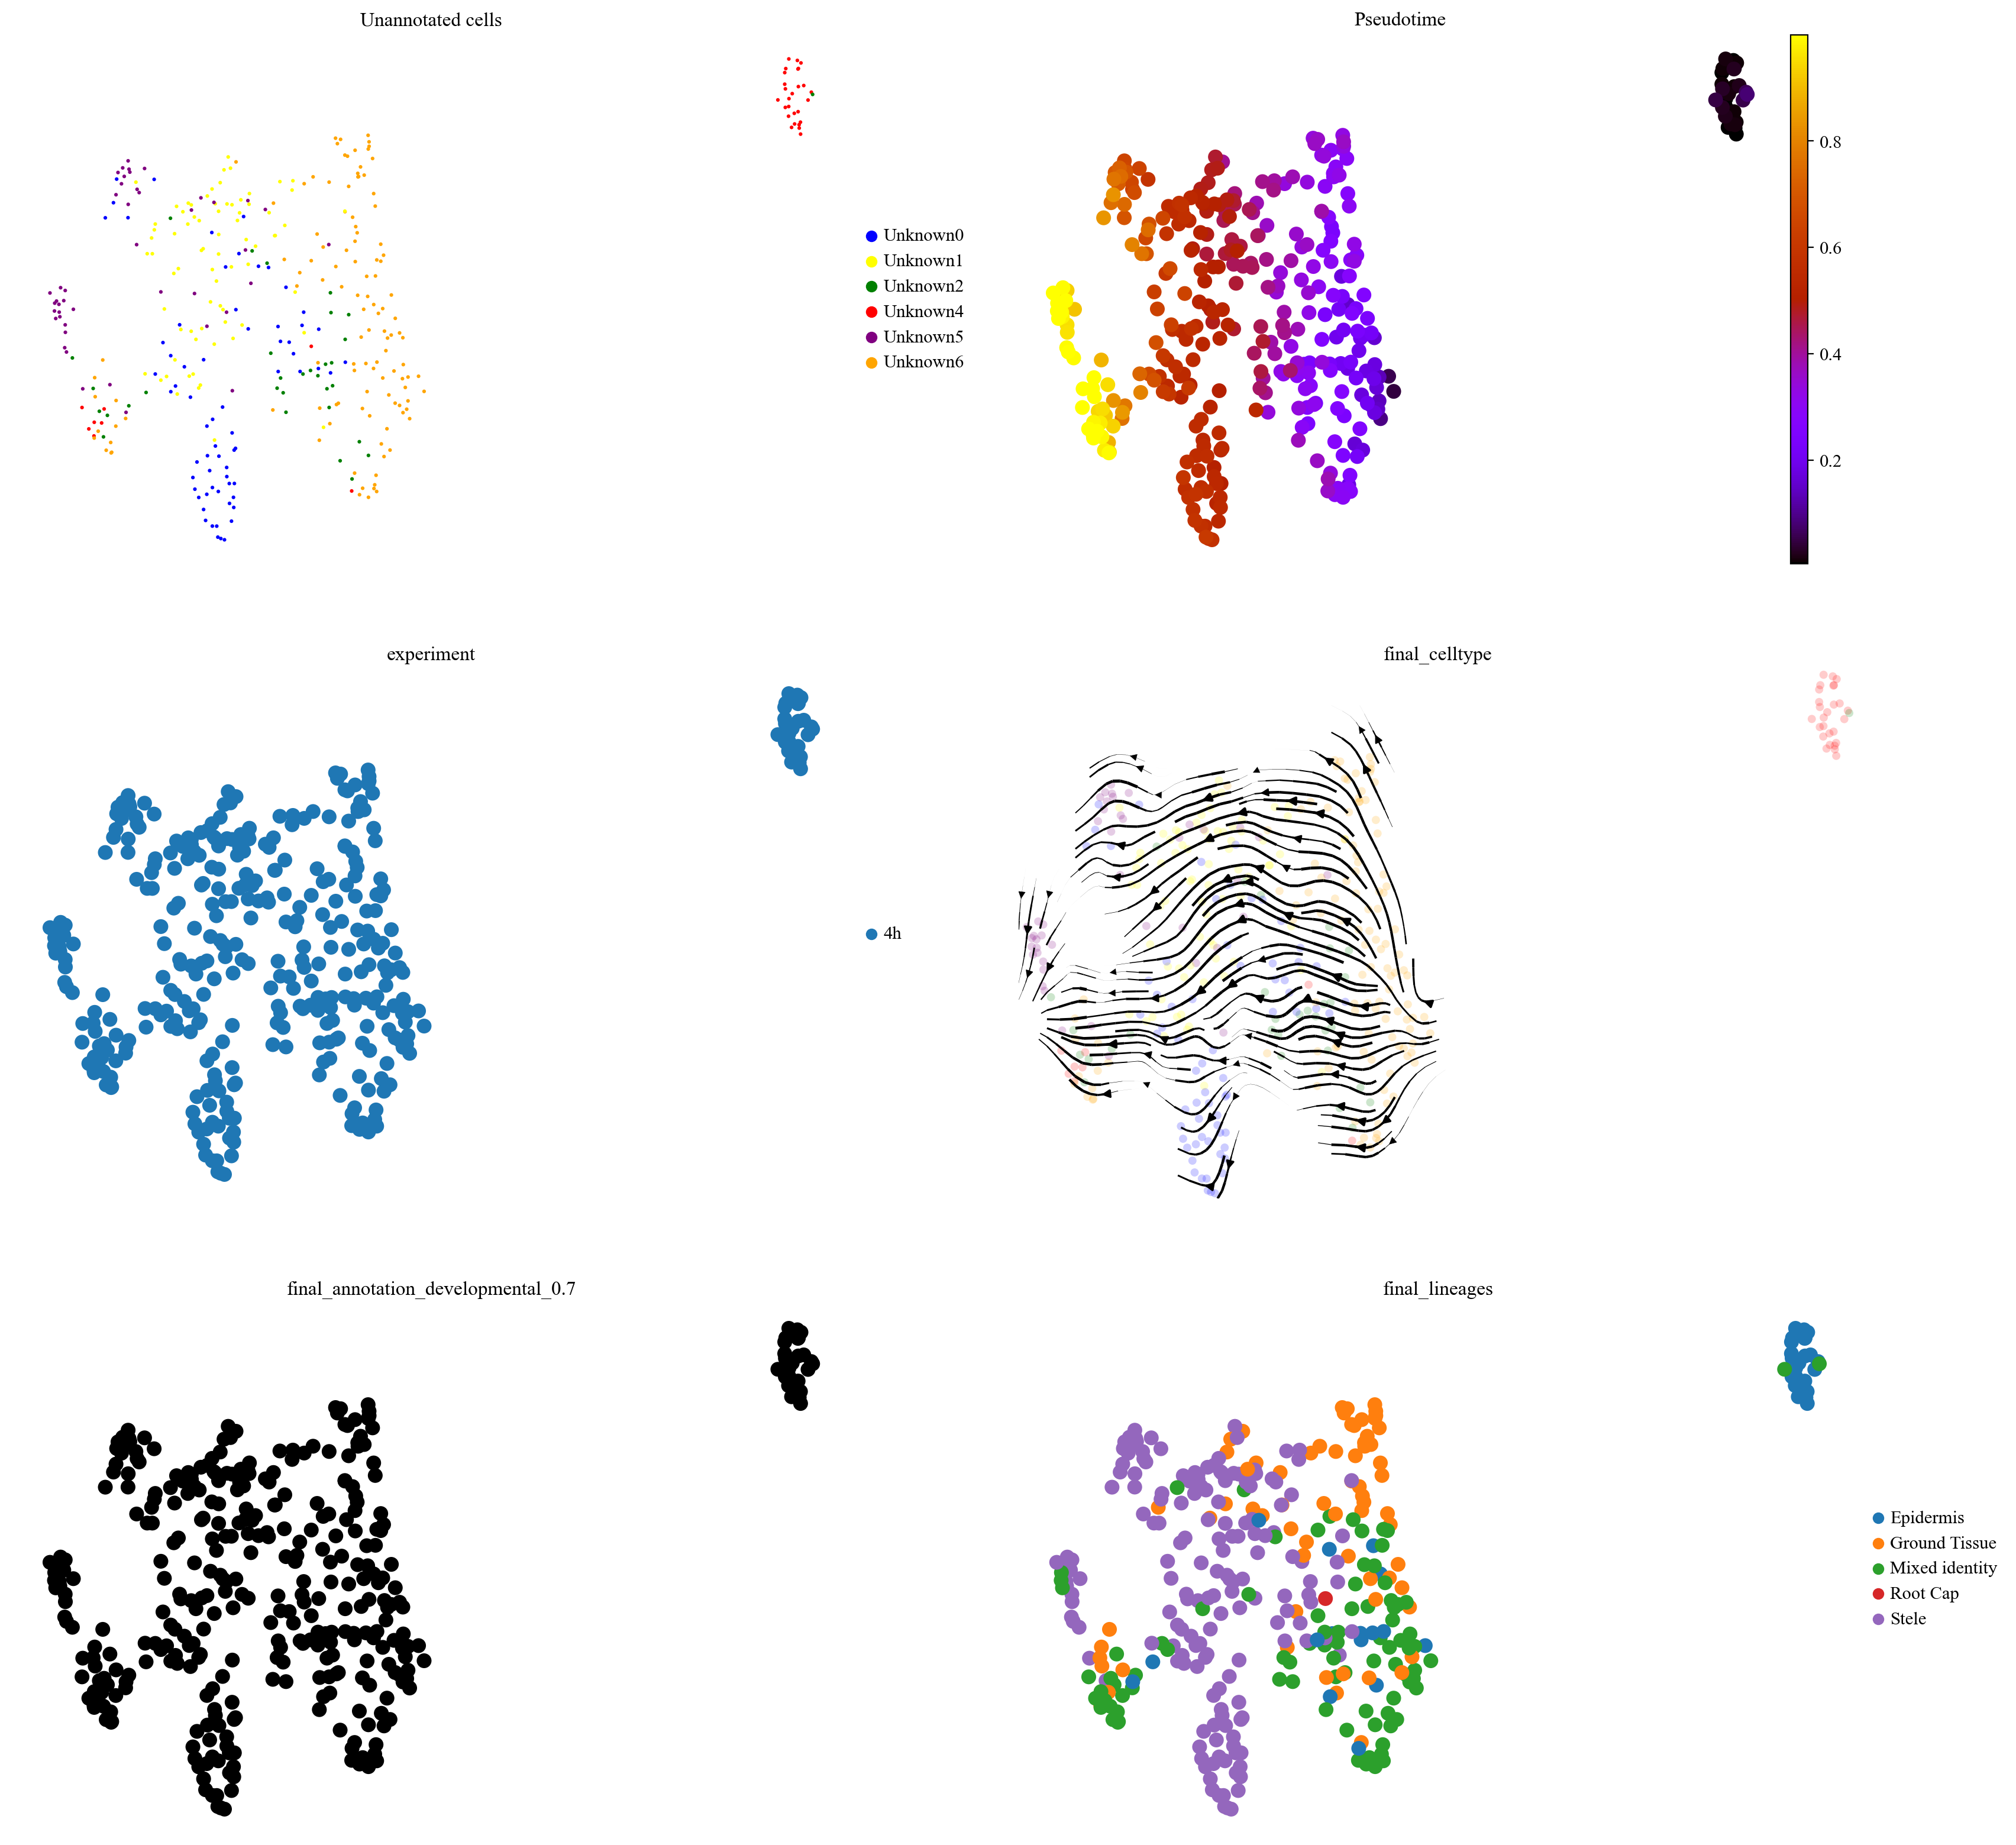

In [ ]:
# Filter clusters of interest (Unknown 0, 1, 2, 4, 5 and 6)
filtered_mask_07 = (adata.obs["final_celltype"] == "Unknown0") | (adata.obs["final_celltype"] == "Unknown1") | (adata.obs["final_celltype"] == "Unknown2") | (adata.obs["final_celltype"] == "Unknown4") | (adata.obs["final_celltype"] == "Unknown5") | (adata.obs["final_celltype"] == "Unknown6")

# Create a new AnnData object with only annotated cells
adata_filtered_07 = adata[filtered_mask_07].copy()

# 4 hours
adata_10h = adata_filtered_07[adata_filtered_07.obs['experiment'].isin(['4h'])].copy()

# Count the number of genes detected in each cell (required by scTour)
sc.pp.calculate_qc_metrics(adata_10h, percent_top=None, log1p=False, inplace=True)

# Select 2000 HVGs
sc.pp.highly_variable_genes(adata_10h, flavor='seurat_v3', n_top_genes=2000, subset=True)

# Train with default parameters
tnode = sct.train.Trainer(adata_10h, loss_mode='nb', alpha_recon_lec=0.5, alpha_recon_lode=0.5)
tnode.train()

# Get pseudotime
adata_10h.obs['ptime'] = tnode.get_time()

# zs represents the latent z from variational inference, and pred_zs represents the latent z from ODE solver
# mix_zs represents the weighted combination of the two, which is used for downstream analysis
# Get latent space
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
adata_10h.obsm['X_TNODE'] = mix_zs

# Get vector field
adata_10h.obsm['X_VF'] = tnode.get_vector_field(adata_10h.obs['ptime'].values, adata_10h.obsm['X_TNODE'])

# Sort pseudotime values
adata_10h = adata_10h[np.argsort(adata_10h.obs['ptime'].values), :]
sc.pp.neighbors(adata_10h, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata_10h, min_dist=0.3)

custom_palette = {
    "Atrichoblast": "#E69F00", 
    "Columella": "#56B4E9", 
    "Cortex": "#009E73", 
    "Endodermis": "#F0E442", 
    "Lateral Root Cap": "#0072B2", 
    "Metaphloem & Companion Cell": "#D55E00", 
    "Metaxylem": "#CC79A7", 
    "Phloem Pole Pericycle": "#F0E442", 
    "Procambium": "#8C564B", 
    "Protophloem": "#9B59B6", 
    "Protoxylem": "#1F77B4", 
    "Quiescent Center": "#2CA02C",
    "Trichoblast": "#D62728", 
    "Xylem Pole Pericycle": "#9467BD",
    "Unknown0": "blue",
    "Unknown1": "yellow", 
    "Unknown2": "green",
    "Unknown3": "pink",
    "Unknown4": "red",
    "Unknown5": "purple",
    "Unknown6": "orange",
    "Unknown7": "magenta",
    "Unknown8": "olive",
    "Unknown9": "black",
    "Unknown10": "khaki",
    "Unknown11": "darkslategrey"
}

custom_palette_developmental = {
        "Distal Columella": "#E69F00", 
        "Proximal Columella": "#56B4E9", 
        "Distal Lateral Root Cap": "#009E73", 
        "Proximal Lateral Root Cap": "#F0E442", 
        "Meristem": "#0072B2", 
        "Elongation": "#D55E00", 
        "Maturation": "#CC79A7",
        "": "#000000" 
}

# Multiple plots (different formats, variables, etc)
fig, axs = pl.subplots(ncols=2, nrows=3, figsize=(20, 20))
sc.pl.umap(adata_10h, color='final_celltype', ax=axs[0, 0], legend_loc="right margin", show=False, frameon=False, palette=custom_palette, title="Unannotated cells", size=20)
sc.pl.umap(adata_10h, color='experiment', ax=axs[1, 0], show=False, frameon=False)
sc.pl.umap(adata_10h, color='ptime', ax=axs[0, 1], show=False, frameon=False, color_map="gnuplot", title="Pseudotime")
sc.pl.umap(adata_10h, color='final_annotation_developmental_0.7', ax=axs[2, 0], show=False, frameon=False, palette=custom_palette_developmental)
sc.pl.umap(adata_10h, color='final_lineages', ax=axs[2, 1], show=False, frameon=False)
sct.vf.plot_vector_field(adata_10h, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='final_celltype', show=False, ax=axs[1, 1], legend_loc='none', frameon=False, size=100, alpha=0.2)
pl.show()

<AxesSubplot: title={'center': 'Pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

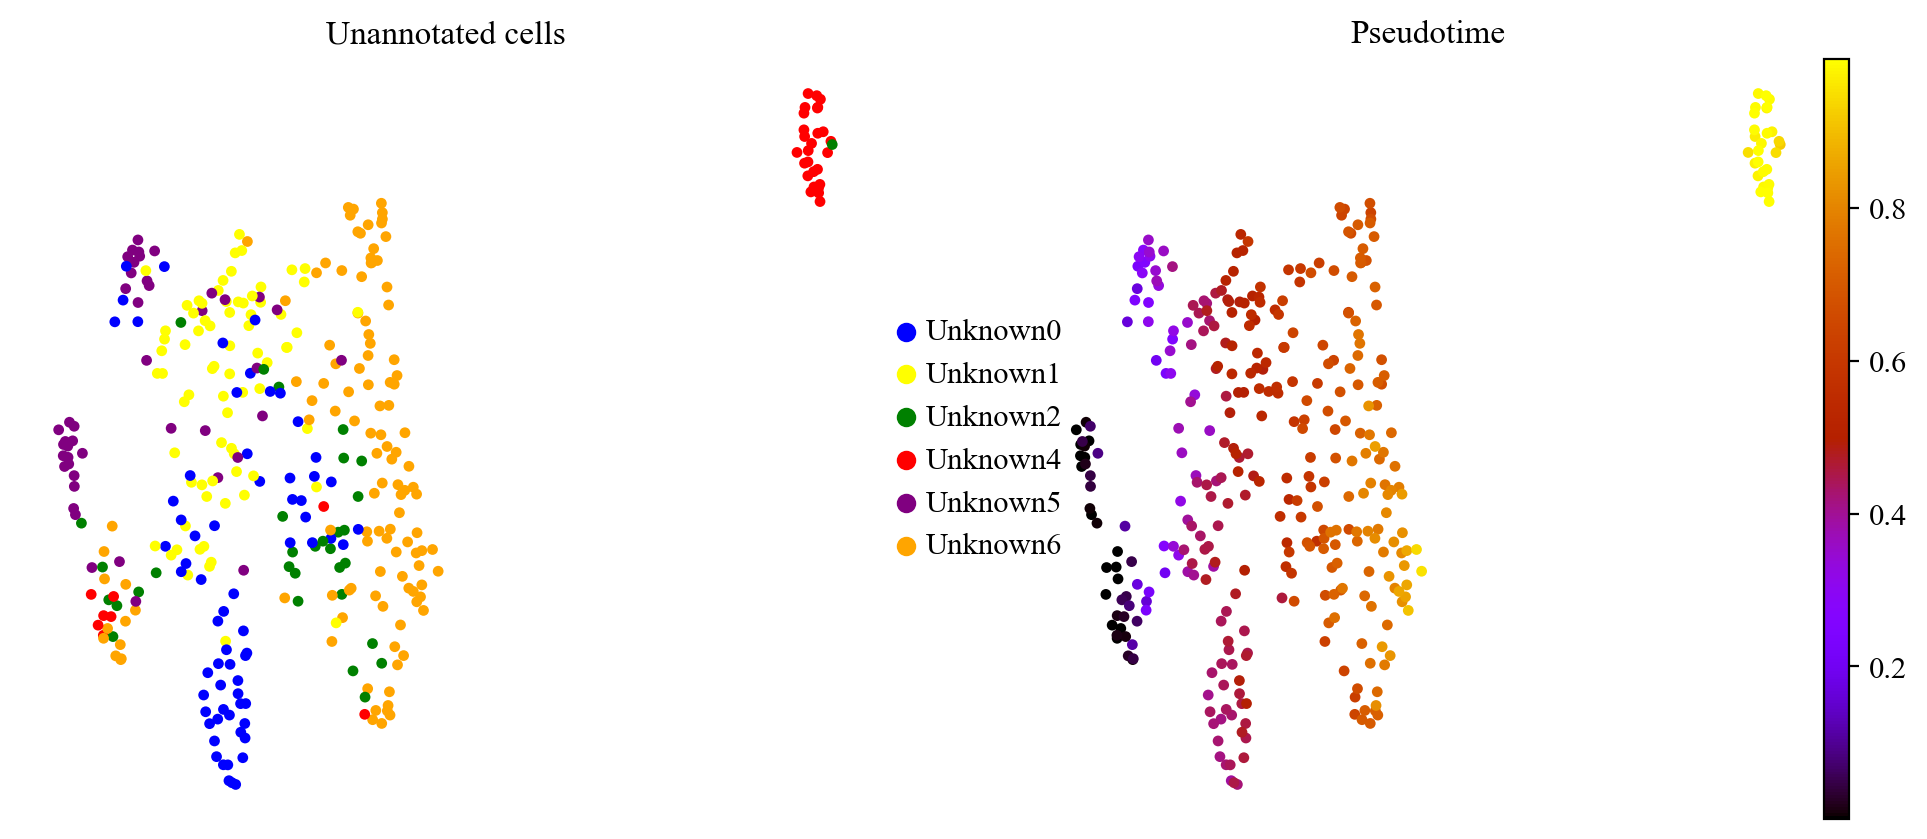

In [ ]:
fig, axs = pl.subplots(ncols=2, nrows=1, figsize=(12, 5))
sc.pl.umap(adata_10h, color='final_celltype', ax=axs[0], legend_loc="right margin", show=False, frameon=False, palette=custom_palette, title="Unannotated cells", size=60)

# Reverse pseudotime
adata_10h.obs['ptime'] = sct.train.reverse_time(adata_10h.obs['ptime'].values)
sc.pl.umap(adata_10h, color='ptime', ax=axs[1], show=False, frameon=False, color_map="gnuplot", title="Pseudotime", size=60)

In [44]:
# Group by 'final_celltype' and calculate the mean latent_time
average_ptime = adata_10h.obs.groupby("final_celltype")["ptime"].mean()

# Print the results
print(average_ptime)

final_celltype
Unknown0    0.466799
Unknown1    0.476356
Unknown2    0.532867
Unknown4    0.798322
Unknown5    0.237454
Unknown6    0.664982
Name: ptime, dtype: float32


**Pseudotime estimation for CellRank**

In [ ]:
# Keep stele cell types except metaxylem and protophloem and unknown0
filtered_mask_07 = (adata.obs["final_celltype"] == "Unknown0") | (adata.obs["final_celltype"] == "Metaphloem & Companion Cell") | \
(adata.obs["final_celltype"] == "Phloem Pole Pericycle") | (adata.obs["final_celltype"] == "Procambium") | (adata.obs["final_celltype"] == "Protoxylem") | \
(adata.obs["final_celltype"] == "Xylem Pole Pericycle")

adata_filtered_07 = adata[filtered_mask_07].copy()

# Keep 0 h
adata_10h = adata_filtered_07[adata_filtered_07.obs['experiment'].isin(['0h'])].copy()

print(adata_10h.obs["final_celltype"].value_counts())

# Get unique cell types
cell_types = adata_10h.obs["final_celltype"].unique()

# Initialize a pseudotime column in the full dataset with NaNs
adata_10h.obs['pseudotime'] = np.nan

# Loop over each cell type
for cell_type in tqdm(cell_types):

    print(f"\nProcessing cell type: {cell_type}")
    # Filter: current cell type only, and only experiment "4h"
    mask = (adata_10h.obs['final_celltype'] == cell_type) & (adata_10h.obs['experiment'] == '0h')
    
    if mask.sum() < 20:
        print(f"Skipping {cell_type}: too few cells ({mask.sum()})")
        continue

    adata_sub = adata_10h[mask].copy()

    # Preprocessing
    sc.pp.calculate_qc_metrics(adata_sub, percent_top=None, log1p=False, inplace=True)
    sc.pp.highly_variable_genes(adata_sub, flavor='seurat_v3', n_top_genes=2000, subset=True)

    # Train TNODE model
    tnode = sct.train.Trainer(adata_sub, loss_mode='nb', alpha_recon_lec=0.5, alpha_recon_lode=0.5)
    tnode.train()

    # Get pseudotime
    ptime = tnode.get_time()
    adata_sub.obs['ptime'] = ptime

    # Add to full adata.obs
    adata_10h.obs.loc[adata_sub.obs_names, 'pseudotime'] = ptime

    # Store latents and vector field
    mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
    adata_sub.obsm['X_TNODE'] = mix_zs
    adata_sub.obsm['X_VF'] = tnode.get_vector_field(ptime, mix_zs)

    # UMAP
    sc.pp.neighbors(adata_sub, use_rep='X_TNODE', n_neighbors=15)
    sc.tl.umap(adata_sub, min_dist=0.3)


print("✅ Pseudotime per cell type computed and stored in adata_10h.obs['pseudotime']")


Xylem Pole Pericycle           2407
Procambium                     1921
Phloem Pole Pericycle          1220
Metaphloem & Companion Cell     716
Protoxylem                      450
Unknown0                        236
Name: final_celltype, dtype: int64


  0%|          | 0/6 [00:00<?, ?it/s]


Processing cell type: Xylem Pole Pericycle
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Running using GPU.
Epoch 400: 100%|██████████| 400/400 [03:41<00:00,  1.81epoch/s, train_loss=832, val_loss=826]

computing neighbors


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)


 17%|█▋        | 1/6 [03:44<18:41, 224.37s/it]


Processing cell type: Procambium
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Running using GPU.
Epoch 400: 100%|██████████| 400/400 [02:43<00:00,  2.45epoch/s, train_loss=780, val_loss=796]

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)


 33%|███▎      | 2/6 [06:29<12:39, 189.76s/it]


Processing cell type: Metaphloem & Companion Cell
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Running using GPU.
Epoch 400: 100%|██████████| 400/400 [01:00<00:00,  6.64epoch/s, train_loss=934, val_loss=948]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


 50%|█████     | 3/6 [07:31<06:33, 131.06s/it]


Processing cell type: Phloem Pole Pericycle
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Running using GPU.
Epoch 400: 100%|██████████| 400/400 [01:45<00:00,  3.80epoch/s, train_loss=936, val_loss=995]

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)


 67%|██████▋   | 4/6 [09:17<04:02, 121.48s/it]


Processing cell type: Protoxylem
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Running using GPU.
Epoch 400: 100%|██████████| 400/400 [00:40<00:00,  9.92epoch/s, train_loss=812, val_loss=783]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


 83%|████████▎ | 5/6 [09:58<01:32, 92.45s/it] 


Processing cell type: Unknown0
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Running using GPU.
Epoch 400: 100%|██████████| 400/400 [00:24<00:00, 16.36epoch/s, train_loss=971, val_loss=885]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


100%|██████████| 6/6 [10:23<00:00, 103.96s/it]

✅ Pseudotime per cell type computed and stored in adata_10h.obs['pseudotime']


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Running using GPU.
Epoch 400: 100%|██████████| 400/400 [09:54<00:00,  1.49s/epoch, train_loss=626, val_loss=635] 


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


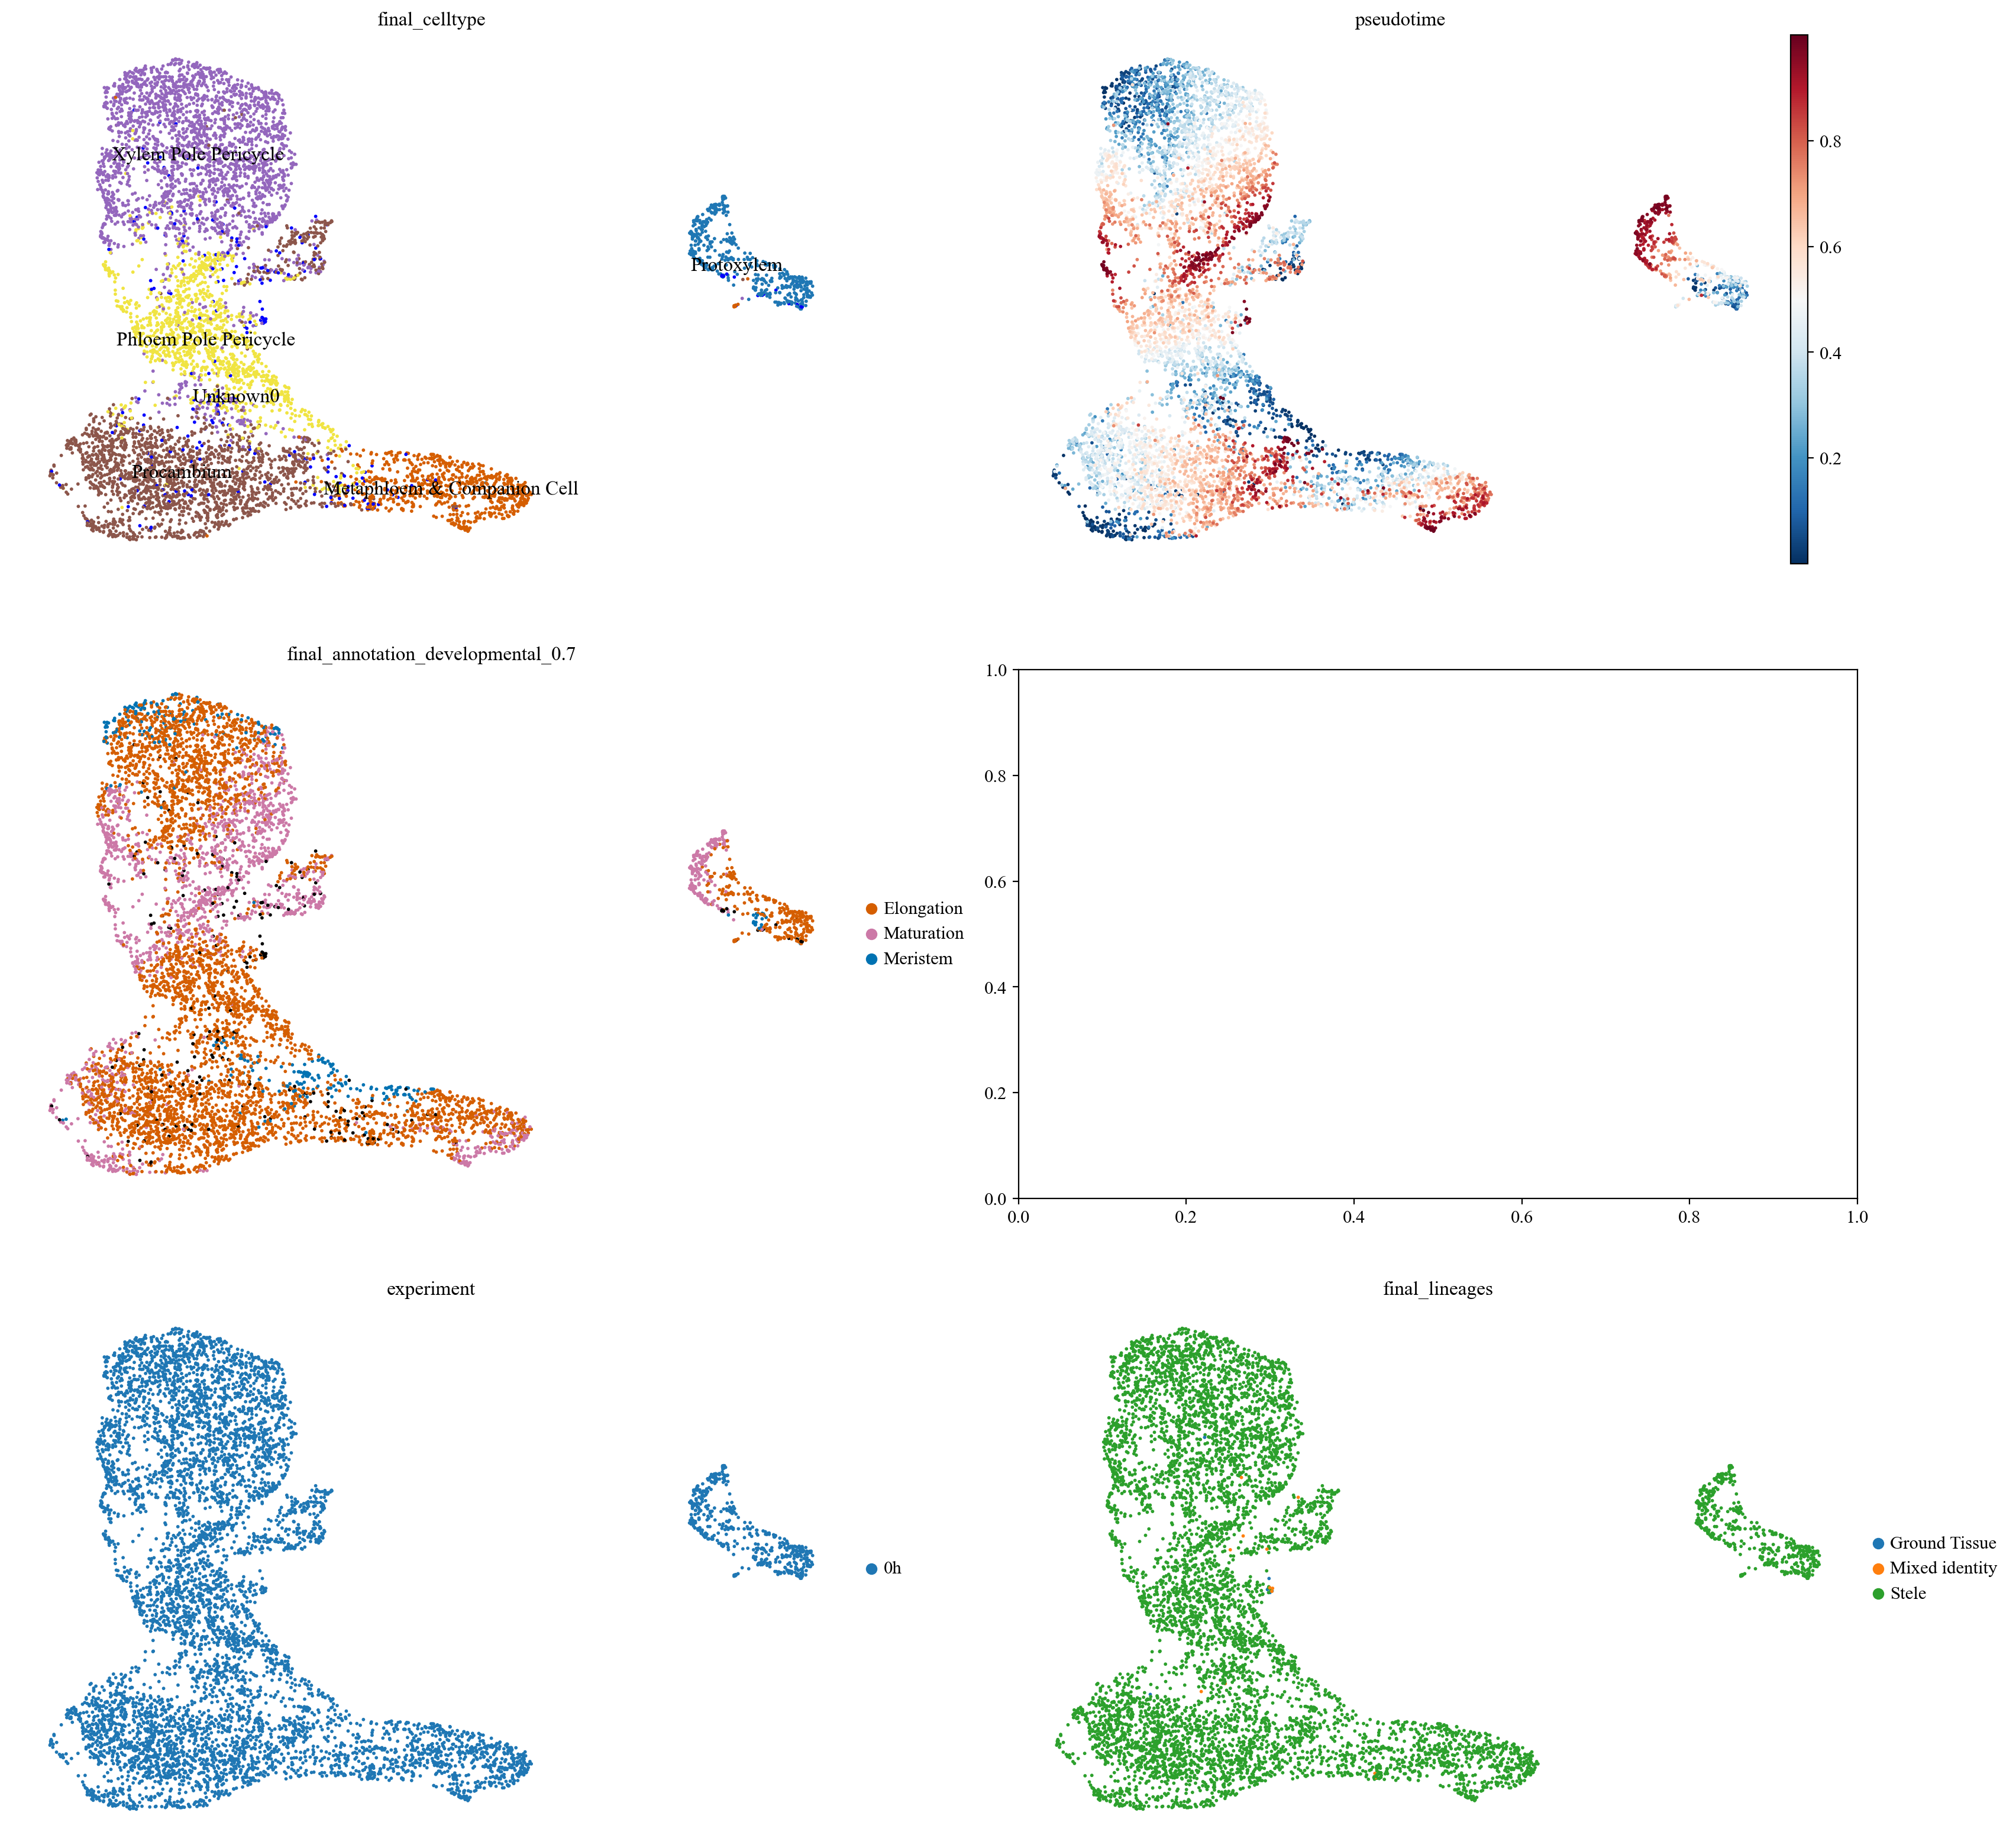

In [ ]:
# Get the representation for the whole dataset by training all the cell types together
filtered_mask_07 = (adata_10h.obs["final_celltype"] == "Unknown0") | (adata_10h.obs["final_celltype"] == "Metaphloem & Companion Cell") | \
(adata_10h.obs["final_celltype"] == "Phloem Pole Pericycle") | (adata_10h.obs["final_celltype"] == "Procambium") | \
(adata_10h.obs["final_celltype"] == "Protoxylem") | (adata_10h.obs["final_celltype"] == "Xylem Pole Pericycle")

adata_filtered_07 = adata_10h[filtered_mask_07].copy()

# Count the number of genes detected in each cell (required by scTour)
sc.pp.calculate_qc_metrics(adata_filtered_07, percent_top=None, log1p=False, inplace=True)

# 2000 HVGs
sc.pp.highly_variable_genes(adata_filtered_07, flavor='seurat_v3', n_top_genes=2000, subset=True)

# Train with default parameters
tnode = sct.train.Trainer(adata_filtered_07, loss_mode='nb', alpha_recon_lec=0.5, alpha_recon_lode=0.5)
tnode.train()

# zs represents the latent z from variational inference, and pred_zs represents the latent z from ODE solver
# mix_zs represents the weighted combination of the two, which is used for downstream analysis
# Get latent space
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
adata_filtered_07.obsm['X_TNODE'] = mix_zs

# UMAP
sc.pp.neighbors(adata_filtered_07, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata_filtered_07, min_dist=0.3)

custom_palette = {
    "Atrichoblast": "#E69F00", 
    "Columella": "#56B4E9", 
    "Cortex": "#009E73", 
    "Endodermis": "#F0E442", 
    "Lateral Root Cap": "#0072B2", 
    "Metaphloem & Companion Cell": "#D55E00", 
    "Metaxylem": "#CC79A7", 
    "Phloem Pole Pericycle": "#F0E442", 
    "Procambium": "#8C564B", 
    "Protophloem": "#9B59B6", 
    "Protoxylem": "#1F77B4", 
    "Quiescent Center": "#2CA02C",
    "Trichoblast": "#D62728", 
    "Xylem Pole Pericycle": "#9467BD",
    "Unknown0": "blue",
    "Unknown1": "yellow", 
    "Unknown2": "green",
    "Unknown3": "pink",
    "Unknown4": "red",
    "Unknown5": "purple",
    "Unknown6": "orange",
    "Unknown7": "magenta",
    "Unknown8": "olive",
    "Unknown9": "black",
    "Unknown10": "khaki",
    "Unknown11": "darkslategrey"
}

custom_palette_developmental = {
        "Distal Columella": "#E69F00", 
        "Proximal Columella": "#56B4E9", 
        "Distal Lateral Root Cap": "#009E73", 
        "Proximal Lateral Root Cap": "#F0E442", 
        "Meristem": "#0072B2", 
        "Elongation": "#D55E00", 
        "Maturation": "#CC79A7",
        "": "#000000" 
}

# Multiple plots (different formats, variables, etc)
fig, axs = pl.subplots(ncols=2, nrows=3, figsize=(20, 20))
sc.pl.umap(adata_filtered_07, color='final_celltype', ax=axs[0, 0], legend_loc="on data", show=False, frameon=False, palette=custom_palette)
sc.pl.umap(adata_filtered_07, color='experiment', ax=axs[2, 0], show=False, frameon=False)
sc.pl.umap(adata_filtered_07, color='pseudotime', ax=axs[0, 1], show=False, frameon=False)
sc.pl.umap(adata_filtered_07, color='final_annotation_developmental_0.7', ax=axs[1, 0], show=False, frameon=False, palette=custom_palette_developmental)
sc.pl.umap(adata_filtered_07, color='final_lineages', ax=axs[2, 1], show=False, frameon=False)
#sct.vf.plot_vector_field(adata_10h, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='final_celltype', show=False, ax=axs[1, 1], legend_loc='none', frameon=False, size=100, alpha=0.2)
pl.show()

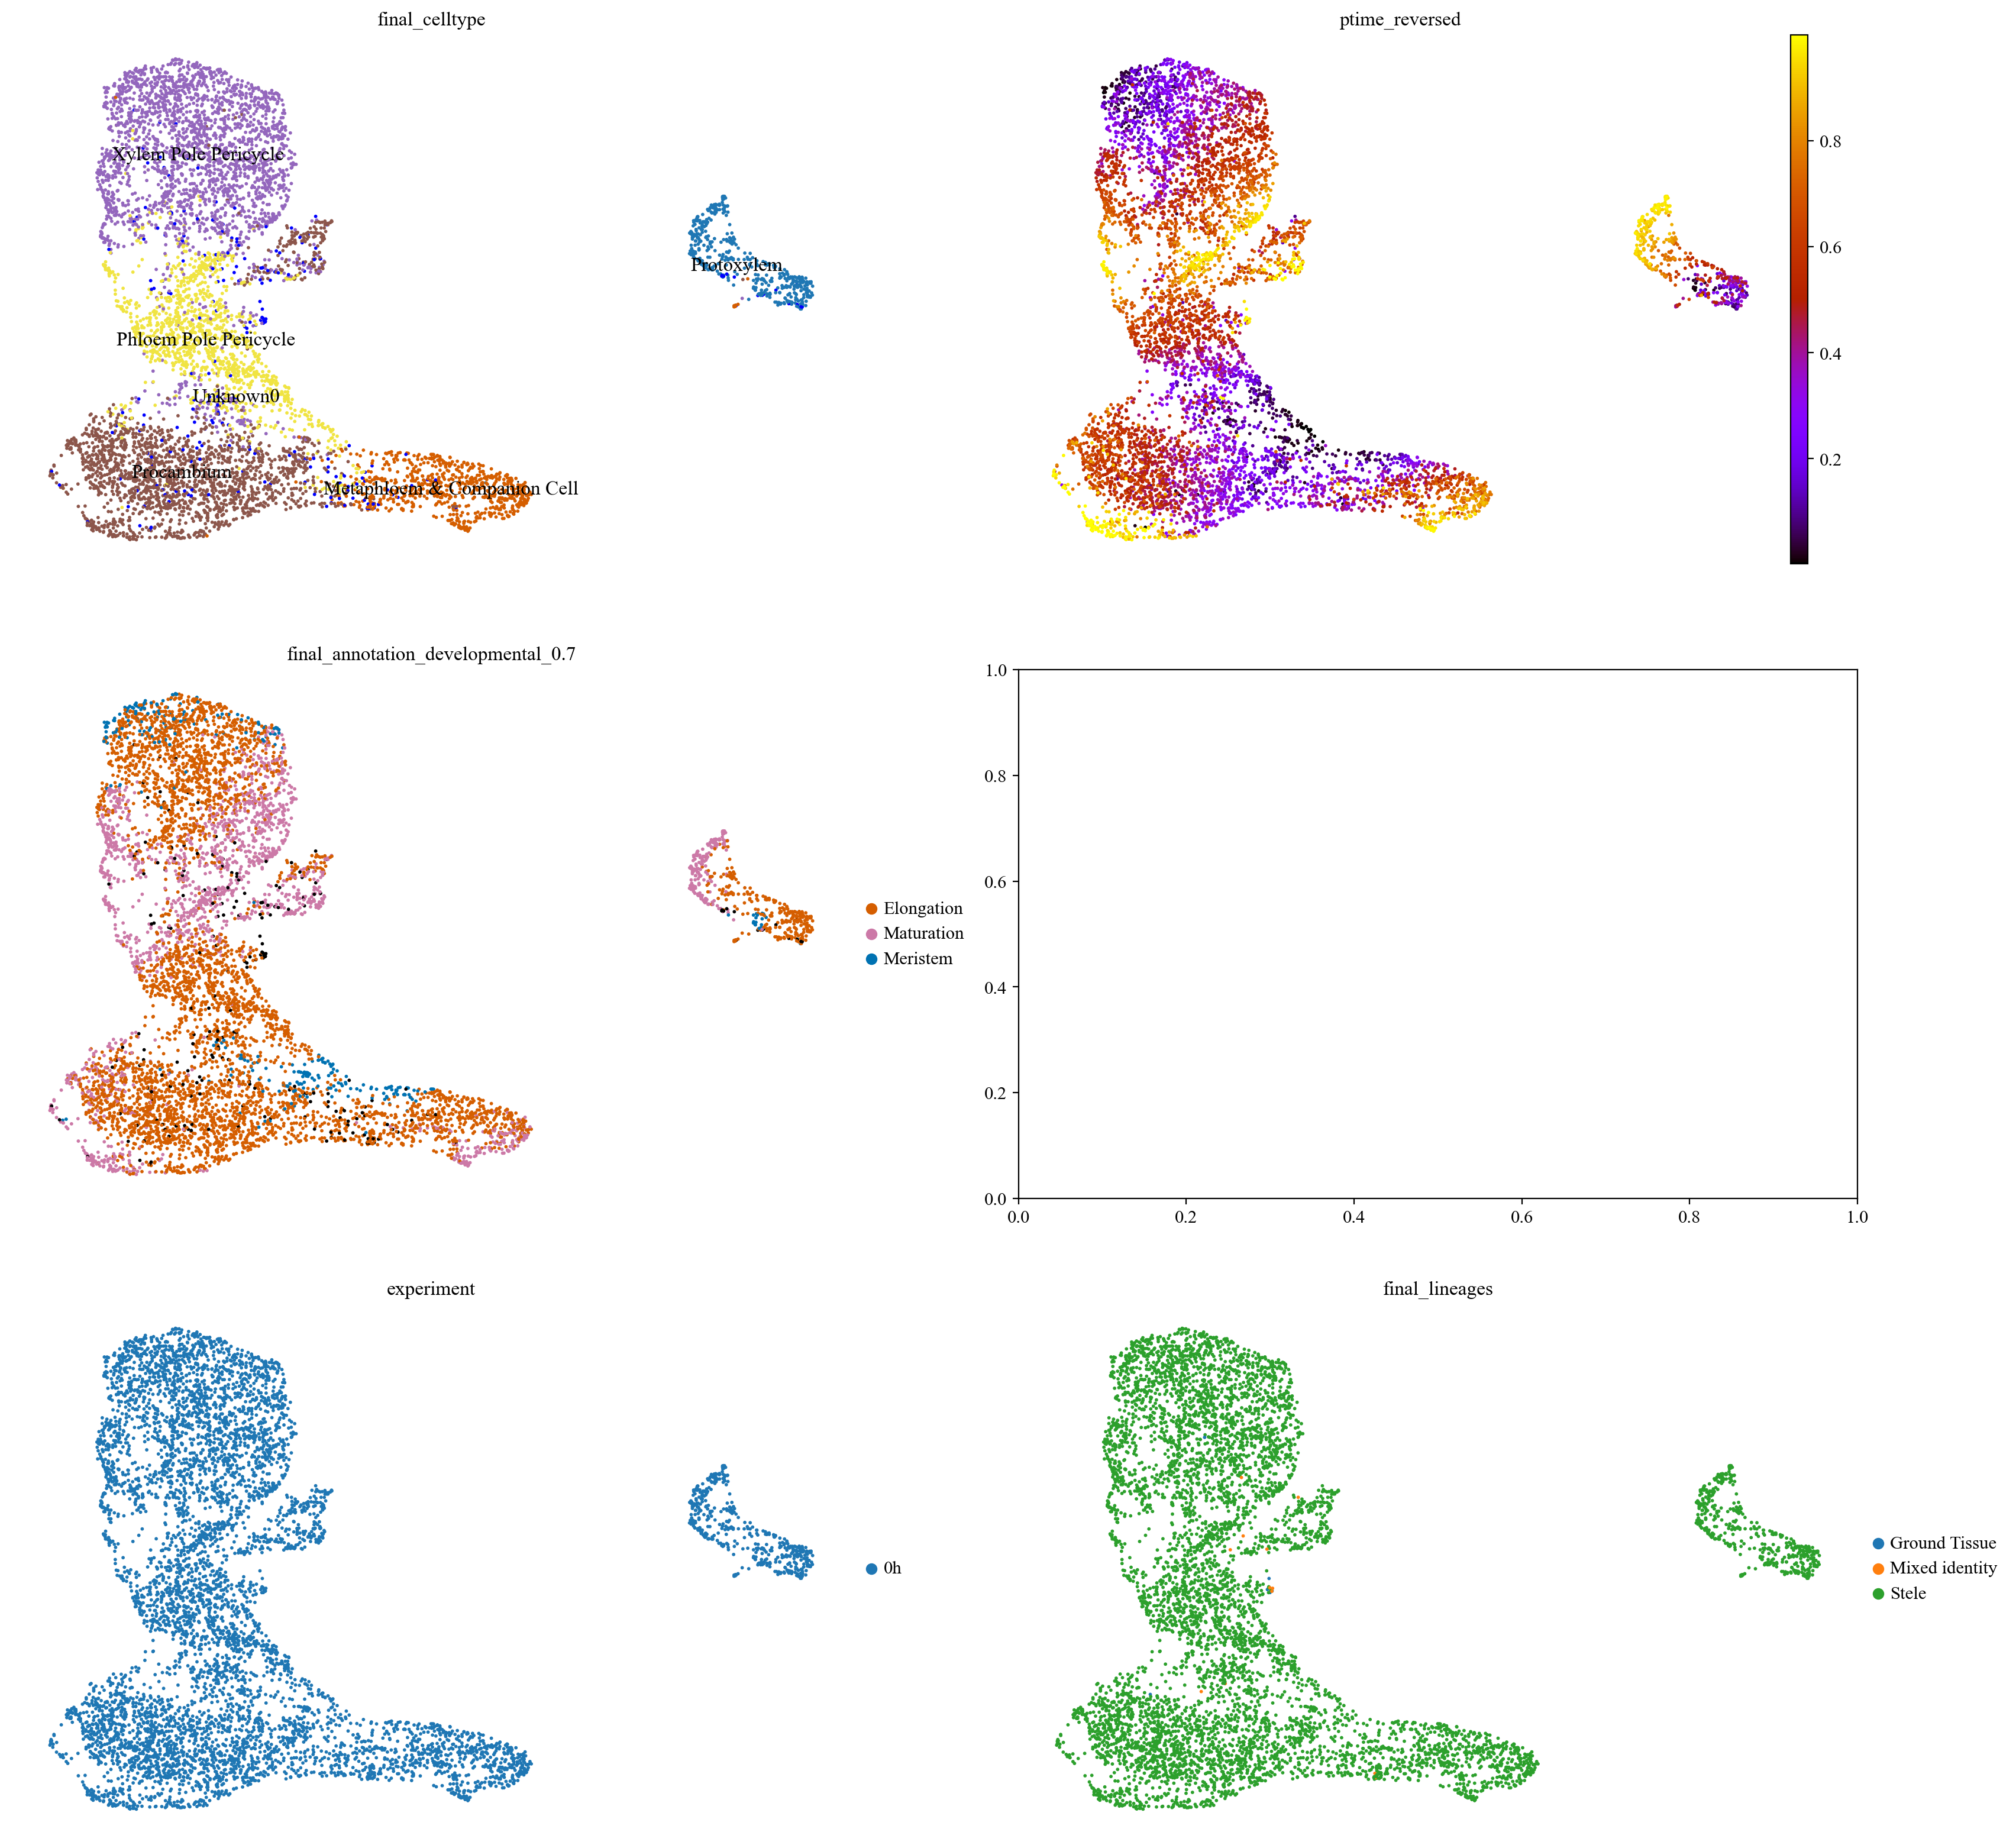

In [ ]:
# Make a copy to avoid changing the original if needed
adata_filtered_07.obs['ptime_reversed'] = adata_filtered_07.obs['pseudotime'].copy()

# Create a mask for "Procambium" cells
procambium_mask = adata_filtered_07.obs['final_celltype'] == 'Procambium'

# Reverse pseudotime only for Procambium cells
adata_filtered_07.obs.loc[procambium_mask, 'ptime_reversed'] = sct.train.reverse_time(
    adata_filtered_07.obs.loc[procambium_mask, 'pseudotime'].values
)

# Multiple plots
fig, axs = pl.subplots(ncols=2, nrows=3, figsize=(20, 20))
sc.pl.umap(adata_filtered_07, color='final_celltype', ax=axs[0, 0], legend_loc="on data", show=False, frameon=False, palette=custom_palette)
sc.pl.umap(adata_filtered_07, color='experiment', ax=axs[2, 0], show=False, frameon=False)
sc.pl.umap(adata_filtered_07, color='ptime_reversed', ax=axs[0, 1], show=False, frameon=False, color_map="gnuplot")
sc.pl.umap(adata_filtered_07, color='final_annotation_developmental_0.7', ax=axs[1, 0], show=False, frameon=False, palette=custom_palette_developmental)
sc.pl.umap(adata_filtered_07, color='final_lineages', ax=axs[2, 1], show=False, frameon=False)
#sct.vf.plot_vector_field(adata_10h, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='final_celltype', show=False, ax=axs[1, 1], legend_loc='none', frameon=False, size=100, alpha=0.2)
pl.show()

In [55]:
adata_filtered_07.write_h5ad('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/3-2_anndata_obj/sctour_pseudotime_0h.h5ad')